In [587]:
import requests
import pandas as pd

In [588]:
# https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l59c/mm23

df = pd.read_csv('Full Database.csv')
df

,Url,Sold,Auction Date,Title,Distillery,Region,Strength,Distillery Status,Cask Type,Currency,...,Cask Filling,Previous Spirit,Regauged Date,Age,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Auction House
0,https://whiskyauctioneer.com/lot/1224-01/cask-...,True,06/01/2025,Port Charlotte 2004 Fresh Bourbon Barrel,Bruichladdich,Islay,50.40,Operational,Barrel,Great Britain Pound (£),...,First Fill,Bourbon,01/10/2024,20.48,212.30,20812.50,87.14,277.87,Scotland,WhiskyAuctioneer
1,https://whiskyauctioneer.com/lot/1124-02a/cask...,False,06/01/2025,Adnams 201Jack Daniel's Barrel,Copper House,England,64.80,Operational,Barrel,Great Britain Pound (£),...,NaN,Bourbon,01/10/2024,13.25,164.86,1125.00,6.07,15.04,England,WhiskyAuctioneer
2,https://whiskyauctioneer.com/lot/1124-01a/cask...,False,06/01/2025,Adnams 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,NaN,NaN,01/10/2024,9.48,247.97,1125.00,4.03,10.08,England,WhiskyAuctioneer
3,https://whiskyauctioneer.com/lot/1124-01/cask-...,False,02/12/2024,Copper House 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,NaN,NaN,01/10/2024,9.39,247.97,281.25,1.01,2.52,England,WhiskyAuctioneer
4,https://whiskyauctioneer.com/lot/0824-05a/cask...,True,02/12/2024,Bruichladdich 2002 Climens Hogshead,Bruichladdich,Islay,53.10,Operational,Hogshead,Great Britain Pound (£),...,NaN,Wine,01/06/2024,NaN,310.20,24187.50,69.31,209.78,Scotland,WhiskyAuctioneer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,https://www.thegrandwhiskyauction.com/lot-6621...,False,06/08/2024,Adnams - Single Malt - French Oak Barrique #482,Adnams,England,64.70,Operational,Barrique,Great Britain Pound (£),...,NaN,NaN,NaN,NaN,250.00,2250.00,9.00,19.87,England,The Grand Whisky Auction
349,https://www.thegrandwhiskyauction.com/lot-6621...,True,06/08/2024,Adnams - Single Malt - French Oak Barrique #468,Adnams,England,68.10,Operational,Barrique,Great Britain Pound (£),...,NaN,NaN,NaN,NaN,242.86,2250.00,9.26,19.44,England,The Grand Whisky Auction
350,https://www.thegrandwhiskyauction.com/lot-6100...,True,14/12/2023,Adnams - Single Malt - Jim Beam - 1st Fill Ame...,Adnams,England,66.41,Operational,Barrel,Great Britain Pound (£),...,First Fill,Bourbon,NaN,NaN,149.57,2137.50,14.29,30.74,England,The Grand Whisky Auction
351,https://www.thegrandwhiskyauction.com/lot-6100...,True,14/12/2023,Adnams - Single Malt - Heaven Hill - 1st Fill ...,Adnams,England,70.20,Operational,Barrel,Great Britain Pound (£),...,First Fill,Bourbon,NaN,NaN,113.86,1800.00,15.81,32.17,England,The Grand Whisky Auction


In [590]:
df['Filling Date'] = pd.to_datetime(df['Filling Date'], format='%d/%m/%Y')

df['Auction Date'] = pd.to_datetime(df['Auction Date'], format='%d/%m/%Y')
df['Year'] = df['Auction Date'].dt.year
df['Month'] = df['Auction Date'].dt.month

df

C:\Users\joaov\AppData\Local\Temp\ipykernel_17716\3542790619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Filling Date'] = pd.to_datetime(df['Filling Date'], format='%d/%m/%Y')
C:\Users\joaov\AppData\Local\Temp\ipykernel_17716\3542790619.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Auction Date'] = pd.to_datetime(df['Auction Date'], format='%d/%m/%Y')
C:\Users\joaov\AppData\Local\Temp\ipykernel_17716\3542790619.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,Url,Sold,Auction Date,Title,Distillery,Region,Strength,Distillery Status,Cask Type,Currency,...,Regauged Date,Age,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Auction House,Year,Month
0,https://whiskyauctioneer.com/lot/1224-01/cask-...,True,2025-01-06,Port Charlotte 2004 Fresh Bourbon Barrel,Bruichladdich,Islay,50.40,Operational,Barrel,Great Britain Pound (£),...,01/10/2024,20.48,212.30,20812.5,87.14,277.87,Scotland,WhiskyAuctioneer,2025,1
4,https://whiskyauctioneer.com/lot/0824-05a/cask...,True,2024-12-02,Bruichladdich 2002 Climens Hogshead,Bruichladdich,Islay,53.10,Operational,Hogshead,Great Britain Pound (£),...,01/06/2024,NaN,310.20,24187.5,69.31,209.78,Scotland,WhiskyAuctioneer,2024,12
16,https://whiskyauctioneer.com/lot/0824-02/cask-...,True,2024-09-09,Heaven Hill 2009 Barrel,Heaven Hill Bernheim,"Kentucky, USA",66.40,Operational,Barrel,Great Britain Pound (£),...,NaN,NaN,226.14,10237.5,40.24,97.40,USA,WhiskyAuctioneer,2024,9
17,https://whiskyauctioneer.com/lot/0824-03/cask-...,True,2024-09-09,Heaven Hill 2009 Barrel,Heaven Hill Bernheim,"Kentucky, USA",65.60,Operational,Barrel,Great Britain Pound (£),...,NaN,NaN,211.14,9900.0,41.68,102.10,USA,WhiskyAuctioneer,2024,9
18,https://whiskyauctioneer.com/lot/0824-04/cask-...,True,2024-09-09,Heaven Hill 2009 Barrel,Heaven Hill Bernheim,"Kentucky, USA",62.50,Operational,Barrel,Great Britain Pound (£),...,NaN,NaN,236.43,9900.0,37.22,95.71,USA,WhiskyAuctioneer,2024,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,https://www.thegrandwhiskyauction.com/lot-6100...,True,2023-12-14,Adnams - Single Malt - Jim Beam - 1st Fill Ame...,Adnams,England,66.39,Operational,Barrel,Great Britain Pound (£),...,NaN,NaN,176.14,2475.0,14.05,30.23,England,The Grand Whisky Auction,2023,12
349,https://www.thegrandwhiskyauction.com/lot-6621...,True,2024-08-06,Adnams - Single Malt - French Oak Barrique #468,Adnams,England,68.10,Operational,Barrique,Great Britain Pound (£),...,NaN,NaN,242.86,2250.0,9.26,19.44,England,The Grand Whisky Auction,2024,8
350,https://www.thegrandwhiskyauction.com/lot-6100...,True,2023-12-14,Adnams - Single Malt - Jim Beam - 1st Fill Ame...,Adnams,England,66.41,Operational,Barrel,Great Britain Pound (£),...,NaN,NaN,149.57,2137.5,14.29,30.74,England,The Grand Whisky Auction,2023,12
351,https://www.thegrandwhiskyauction.com/lot-6100...,True,2023-12-14,Adnams - Single Malt - Heaven Hill - 1st Fill ...,Adnams,England,70.20,Operational,Barrel,Great Britain Pound (£),...,NaN,NaN,113.86,1800.0,15.81,32.17,England,The Grand Whisky Auction,2023,12


In [591]:
df.drop(columns=['Url','Sold','Title','Currency','Filling Date','Regauged Date','Auction House'], inplace=True)
df

C:\Users\joaov\AppData\Local\Temp\ipykernel_17716\3709931634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Url','Sold','Title','Currency','Filling Date','Regauged Date','Auction House'], inplace=True)


,Auction Date,Distillery,Region,Strength,Distillery Status,Cask Type,Bulk Litres,Rla,Cask Filling,Previous Spirit,Age,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Year,Month
0,2025-01-06,Bruichladdich,Islay,50.40,Operational,Barrel,148.61,74.90,First Fill,Bourbon,20.48,212.30,20812.5,87.14,277.87,Scotland,2025,1
4,2024-12-02,Bruichladdich,Islay,53.10,Operational,Hogshead,217.14,115.30,NaN,Wine,NaN,310.20,24187.5,69.31,209.78,Scotland,2024,12
16,2024-09-09,Heaven Hill Bernheim,"Kentucky, USA",66.40,Operational,Barrel,158.30,105.11,NaN,Bourbon,NaN,226.14,10237.5,40.24,97.40,USA,2024,9
17,2024-09-09,Heaven Hill Bernheim,"Kentucky, USA",65.60,Operational,Barrel,147.80,96.96,NaN,Bourbon,NaN,211.14,9900.0,41.68,102.10,USA,2024,9
18,2024-09-09,Heaven Hill Bernheim,"Kentucky, USA",62.50,Operational,Barrel,165.50,103.44,NaN,Bourbon,NaN,236.43,9900.0,37.22,95.71,USA,2024,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,2023-12-14,Adnams,England,66.39,Operational,Barrel,123.30,81.86,First Fill,Bourbon,NaN,176.14,2475.0,14.05,30.23,England,2023,12
349,2024-08-06,Adnams,England,68.10,Operational,Barrique,170.00,115.77,NaN,NaN,NaN,242.86,2250.0,9.26,19.44,England,2024,8
350,2023-12-14,Adnams,England,66.41,Operational,Barrel,104.70,69.53,First Fill,Bourbon,NaN,149.57,2137.5,14.29,30.74,England,2023,12
351,2023-12-14,Adnams,England,70.20,Operational,Barrel,79.70,55.95,First Fill,Bourbon,NaN,113.86,1800.0,15.81,32.17,England,2023,12


In [592]:
df_inflation_gbp = pd.read_csv('series-110625.csv')
df_inflation_gbp

,Title,CPIH MONTHLY RATE 00: ALL ITEMS 2015=100
0,CDID,L59C
1,Source dataset ID,MM23
2,PreUnit,NaN
3,Unit,%
4,Release date,21-05-2025
...,...,...
510,2024 DEC,0.3
511,2025 JAN,0.0
512,2025 FEB,0.4
513,2025 MAR,0.3


In [593]:
df_inflation_gbp = df_inflation_gbp.iloc[68:]
df_inflation_gbp

,Title,CPIH MONTHLY RATE 00: ALL ITEMS 2015=100
68,1988 FEB,0.3
69,1988 MAR,0.4
70,1988 APR,1.3
71,1988 MAY,0.5
72,1988 JUN,0.3
...,...,...
510,2024 DEC,0.3
511,2025 JAN,0.0
512,2025 FEB,0.4
513,2025 MAR,0.3


In [594]:
df_inflation_gbp.columns = ['Date', 'Inflation Rate']

In [595]:
df_inflation_gbp['Date'] = pd.to_datetime(df_inflation_gbp['Date'])
df_inflation_gbp['Year'] = df_inflation_gbp['Date'].dt.year
df_inflation_gbp['Month'] = df_inflation_gbp['Date'].dt.month
df_inflation_gbp['Inflation Rate'] = round(df_inflation_gbp['Inflation Rate'].astype(float) / 100, 6)
df_inflation_gbp

C:\Users\joaov\AppData\Local\Temp\ipykernel_17716\2859149626.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_inflation_gbp['Date'] = pd.to_datetime(df_inflation_gbp['Date'])
C:\Users\joaov\AppData\Local\Temp\ipykernel_17716\2859149626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inflation_gbp['Date'] = pd.to_datetime(df_inflation_gbp['Date'])
C:\Users\joaov\AppData\Local\Temp\ipykernel_17716\2859149626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,Date,Inflation Rate,Year,Month
68,1988-02-01,0.003,1988,2
69,1988-03-01,0.004,1988,3
70,1988-04-01,0.013,1988,4
71,1988-05-01,0.005,1988,5
72,1988-06-01,0.003,1988,6
...,...,...,...,...
510,2024-12-01,0.003,2024,12
511,2025-01-01,0.000,2025,1
512,2025-02-01,0.004,2025,2
513,2025-03-01,0.003,2025,3


In [596]:
df_inflation_gbp = df_inflation_gbp[df_inflation_gbp['Date'] >= '2010-01-01'].reset_index(drop=True)
df_inflation_gbp

,Date,Inflation Rate,Year,Month
0,2010-01-01,-0.002,2010,1
1,2010-02-01,0.003,2010,2
2,2010-03-01,0.004,2010,3
3,2010-04-01,0.005,2010,4
4,2010-05-01,0.002,2010,5
...,...,...,...,...
179,2024-12-01,0.003,2024,12
180,2025-01-01,0.000,2025,1
181,2025-02-01,0.004,2025,2
182,2025-03-01,0.003,2025,3


In [597]:
df_inflation_gbp['Accumulated Inflation'] = (1 + df_inflation_gbp['Inflation Rate'])[::-1].cumprod()[::-1] - 1
df_inflation_gbp['Adjust Value'] = df_inflation_gbp['Accumulated Inflation'] + 1
df_inflation_gbp.drop(columns=['Date','Inflation Rate','Accumulated Inflation'], inplace=True)
df_inflation_gbp

,Year,Month,Adjust Value
0,2010,1,1.548552
1,2010,2,1.551656
2,2010,3,1.547014
3,2010,4,1.540851
4,2010,5,1.533185
...,...,...,...
179,2024,12,1.022153
180,2025,1,1.019096
181,2025,2,1.019096
182,2025,3,1.015036


In [598]:
df = df.merge(df_inflation_gbp, on=['Year', 'Month'], how='left')
df

,Auction Date,Distillery,Region,Strength,Distillery Status,Cask Type,Bulk Litres,Rla,Cask Filling,Previous Spirit,Age,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Year,Month,Adjust Value
0,2025-01-06,Bruichladdich,Islay,50.40,Operational,Barrel,148.61,74.90,First Fill,Bourbon,20.48,212.30,20812.5,87.14,277.87,Scotland,2025,1,1.019096
1,2024-12-02,Bruichladdich,Islay,53.10,Operational,Hogshead,217.14,115.30,NaN,Wine,NaN,310.20,24187.5,69.31,209.78,Scotland,2024,12,1.022153
2,2024-09-09,Heaven Hill Bernheim,"Kentucky, USA",66.40,Operational,Barrel,158.30,105.11,NaN,Bourbon,NaN,226.14,10237.5,40.24,97.40,USA,2024,9,1.031373
3,2024-09-09,Heaven Hill Bernheim,"Kentucky, USA",65.60,Operational,Barrel,147.80,96.96,NaN,Bourbon,NaN,211.14,9900.0,41.68,102.10,USA,2024,9,1.031373
4,2024-09-09,Heaven Hill Bernheim,"Kentucky, USA",62.50,Operational,Barrel,165.50,103.44,NaN,Bourbon,NaN,236.43,9900.0,37.22,95.71,USA,2024,9,1.031373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2023-12-14,Adnams,England,66.39,Operational,Barrel,123.30,81.86,First Fill,Bourbon,NaN,176.14,2475.0,14.05,30.23,England,2023,12,1.059513
184,2024-08-06,Adnams,England,68.10,Operational,Barrique,170.00,115.77,NaN,NaN,NaN,242.86,2250.0,9.26,19.44,England,2024,8,1.035499
185,2023-12-14,Adnams,England,66.41,Operational,Barrel,104.70,69.53,First Fill,Bourbon,NaN,149.57,2137.5,14.29,30.74,England,2023,12,1.059513
186,2023-12-14,Adnams,England,70.20,Operational,Barrel,79.70,55.95,First Fill,Bourbon,NaN,113.86,1800.0,15.81,32.17,England,2023,12,1.059513


In [599]:
df['Adjust Buyer Price'] = round(df['Buyer Price'] * df['Adjust Value'], 2)
df

,Auction Date,Distillery,Region,Strength,Distillery Status,Cask Type,Bulk Litres,Rla,Cask Filling,Previous Spirit,Age,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Year,Month,Adjust Value,Adjust Buyer Price
0,2025-01-06,Bruichladdich,Islay,50.40,Operational,Barrel,148.61,74.90,First Fill,Bourbon,20.48,212.30,20812.5,87.14,277.87,Scotland,2025,1,1.019096,21209.94
1,2024-12-02,Bruichladdich,Islay,53.10,Operational,Hogshead,217.14,115.30,NaN,Wine,NaN,310.20,24187.5,69.31,209.78,Scotland,2024,12,1.022153,24723.34
2,2024-09-09,Heaven Hill Bernheim,"Kentucky, USA",66.40,Operational,Barrel,158.30,105.11,NaN,Bourbon,NaN,226.14,10237.5,40.24,97.40,USA,2024,9,1.031373,10558.68
3,2024-09-09,Heaven Hill Bernheim,"Kentucky, USA",65.60,Operational,Barrel,147.80,96.96,NaN,Bourbon,NaN,211.14,9900.0,41.68,102.10,USA,2024,9,1.031373,10210.60
4,2024-09-09,Heaven Hill Bernheim,"Kentucky, USA",62.50,Operational,Barrel,165.50,103.44,NaN,Bourbon,NaN,236.43,9900.0,37.22,95.71,USA,2024,9,1.031373,10210.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2023-12-14,Adnams,England,66.39,Operational,Barrel,123.30,81.86,First Fill,Bourbon,NaN,176.14,2475.0,14.05,30.23,England,2023,12,1.059513,2622.29
184,2024-08-06,Adnams,England,68.10,Operational,Barrique,170.00,115.77,NaN,NaN,NaN,242.86,2250.0,9.26,19.44,England,2024,8,1.035499,2329.87
185,2023-12-14,Adnams,England,66.41,Operational,Barrel,104.70,69.53,First Fill,Bourbon,NaN,149.57,2137.5,14.29,30.74,England,2023,12,1.059513,2264.71
186,2023-12-14,Adnams,England,70.20,Operational,Barrel,79.70,55.95,First Fill,Bourbon,NaN,113.86,1800.0,15.81,32.17,England,2023,12,1.059513,1907.12


In [600]:
df.sort_values('Auction Date', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

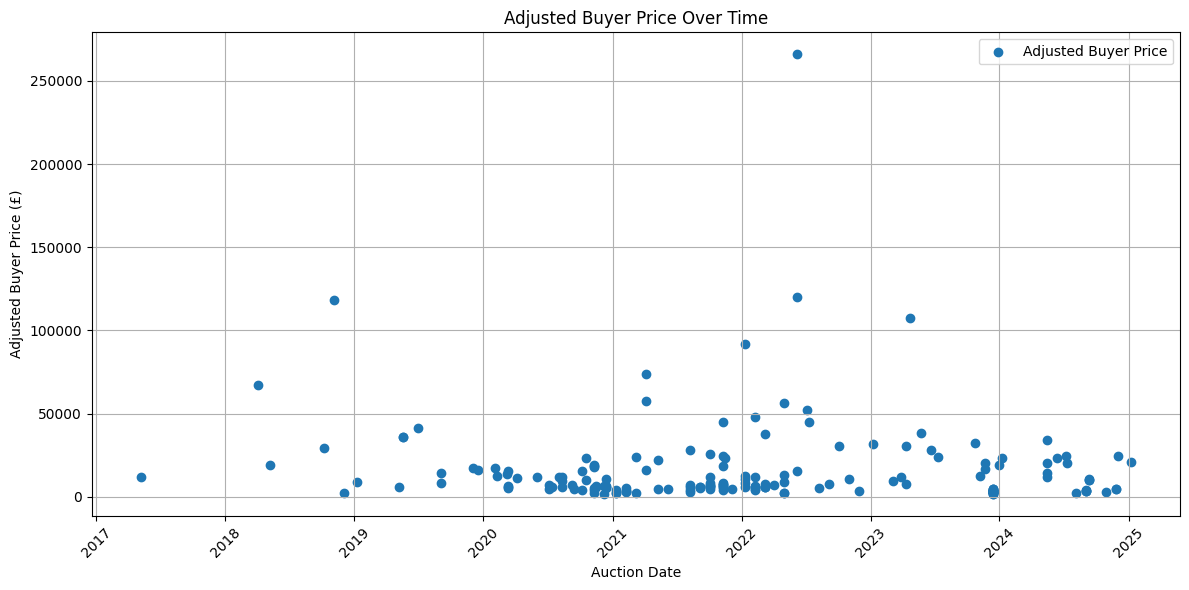

In [601]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.scatter(df['Auction Date'], df['Adjust Buyer Price'], label='Adjusted Buyer Price', marker='o')
plt.title('Adjusted Buyer Price Over Time')
plt.xlabel('Auction Date')
plt.ylabel('Adjusted Buyer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [602]:
df.drop(columns=['Buyer Price', 'Adjust Value', 'Year', 'Month', 'Auction Date', 'Cask Type','Cask Filling','Previous Spirit'], inplace=True)
df

,Distillery,Region,Strength,Distillery Status,Bulk Litres,Rla,Age,Bottles At Cask Strength,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Adjust Buyer Price
0,Bruichladdich,Islay,50.4,Operational,148.61,74.90,20.48,212.30,87.14,277.87,Scotland,21209.94
1,Bruichladdich,Islay,53.1,Operational,217.14,115.30,NaN,310.20,69.31,209.78,Scotland,24723.34
2,Adnams,England,70.1,Operational,168.86,118.37,NaN,241.23,18.65,38.02,England,4608.89
3,Adnams,England,64.0,Operational,185.00,118.40,NaN,264.29,17.03,38.01,England,4608.89
4,Annandale,Lowlands,63.5,Operational,200.00,127.00,NaN,285.71,9.84,22.15,Scotland,2897.84
...,...,...,...,...,...,...,...,...,...,...,...,...
183,Macallan,Speyside,47.8,Operational,159.00,76.00,28.78,227.14,358.81,1206.41,Scotland,118541.00
184,Ben Nevis,Highlands,57.2,Operational,415.59,237.77,21.86,593.70,33.69,94.63,Scotland,29118.91
185,Bruichladdich,Islay,64.1,Operational,201.00,128.84,14.35,287.14,44.75,112.20,Scotland,18896.49
186,Ben Nevis,Highlands,57.2,Operational,398.65,230.76,21.34,569.50,79.82,221.63,Scotland,67118.34


In [603]:
df.drop(columns=['Price Per Bottle At Cask Strength', 'Price Per Litre Of Alcohol'], inplace=True)
df

,Distillery,Region,Strength,Distillery Status,Bulk Litres,Rla,Age,Bottles At Cask Strength,Country,Adjust Buyer Price
0,Bruichladdich,Islay,50.4,Operational,148.61,74.90,20.48,212.30,Scotland,21209.94
1,Bruichladdich,Islay,53.1,Operational,217.14,115.30,NaN,310.20,Scotland,24723.34
2,Adnams,England,70.1,Operational,168.86,118.37,NaN,241.23,England,4608.89
3,Adnams,England,64.0,Operational,185.00,118.40,NaN,264.29,England,4608.89
4,Annandale,Lowlands,63.5,Operational,200.00,127.00,NaN,285.71,Scotland,2897.84
...,...,...,...,...,...,...,...,...,...,...
183,Macallan,Speyside,47.8,Operational,159.00,76.00,28.78,227.14,Scotland,118541.00
184,Ben Nevis,Highlands,57.2,Operational,415.59,237.77,21.86,593.70,Scotland,29118.91
185,Bruichladdich,Islay,64.1,Operational,201.00,128.84,14.35,287.14,Scotland,18896.49
186,Ben Nevis,Highlands,57.2,Operational,398.65,230.76,21.34,569.50,Scotland,67118.34


In [604]:
df.isnull().sum()

Distillery                   2
Region                       1
Strength                     1
Distillery Status            1
Bulk Litres                  5
Rla                          5
Age                         42
Bottles At Cask Strength     5
Country                      2
Adjust Buyer Price           0
dtype: int64

In [605]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

Distillery                  0
Region                      0
Strength                    0
Distillery Status           0
Bulk Litres                 0
Rla                         0
Age                         0
Bottles At Cask Strength    0
Country                     0
Adjust Buyer Price          0
dtype: int64

In [606]:
df = pd.get_dummies(df, columns=['Distillery','Region','Distillery Status','Country'], drop_first=True, dtype=int)
df

,Strength,Bulk Litres,Rla,Age,Bottles At Cask Strength,Adjust Buyer Price,Distillery_Ardmore,Distillery_Arran (Lochranza),Distillery_Aultmore,Distillery_Ben Nevis,...,Region_Highlands,Region_Ireland,Region_Islands,Region_Islay,Region_Lowlands,Region_Speyside,Region_Trinidad,Distillery Status_Operational,Country_Scotland,Country_Trinidad
0,50.40,148.61,74.90,20.48,212.30,21209.94,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
1,58.70,178.00,104.49,12.74,254.29,20095.15,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
2,49.10,166.10,81.56,27.76,237.29,24463.66,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
3,62.20,350.00,217.70,28.56,500.00,23637.14,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
4,55.90,251.00,140.31,19.64,358.57,34279.10,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,61.43,43.27,26.58,3.01,61.81,2249.96,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
134,47.80,159.00,76.00,28.78,227.14,118541.00,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
135,57.20,415.59,237.77,21.86,593.70,29118.91,0,0,0,1,...,1,0,0,0,0,0,0,1,1,0
136,64.10,201.00,128.84,14.35,287.14,18896.49,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0


In [607]:
from sklearn.model_selection import train_test_split

x = df.drop(columns=['Adjust Buyer Price'])
y = df['Adjust Buyer Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((110, 60), (28, 60), (110,), (28,))

In [608]:
from sklearn.preprocessing import StandardScaler

scaler_x_train = StandardScaler()
x_train[['Strength', 'Bulk Litres', 'Rla', 'Age', 'Bottles At Cask Strength']] = scaler_x_train.fit_transform(x_train[['Strength', 'Bulk Litres', 'Rla', 'Age', 'Bottles At Cask Strength']])

scaler_x_test = StandardScaler()
x_test[['Strength', 'Bulk Litres', 'Rla', 'Age', 'Bottles At Cask Strength']] = scaler_x_test.fit_transform(x_test[['Strength', 'Bulk Litres', 'Rla', 'Age', 'Bottles At Cask Strength']])

# ML Models

In [609]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [610]:
models_metrics = {}

## Linear Regression

In [611]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [612]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2:.2f}')

models_metrics['Linear Regression'] = {'RMSE': rmse, 'R^2': r2}

pred_vs_test

RMSE: 45656.65
R^2: 0.12


,Actual,Predicted,Error
0,4220.66,1692.325121,2528.33
1,3834.33,9604.266364,-5769.94
2,12383.90,18185.967432,-5802.07
3,52170.31,24194.372043,27975.94
4,6352.66,15334.722076,-8982.06
5,4695.44,4710.449367,-15.01
6,8562.27,6164.383431,2397.89
7,15715.04,20061.951175,-4346.91
8,9239.92,13656.485540,-4416.57
9,6897.66,6108.040292,789.62


## Random Forest

In [613]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: -12107.66
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

In [614]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2:.2f}')

models_metrics['Linear Regression'] = {'RMSE': rmse, 'R^2': r2}

pred_vs_test

RMSE: 41171.39
R^2: 0.29


,Actual,Predicted,Error
0,4220.66,4273.9596,-53.30
1,3834.33,10371.1186,-6536.79
2,12383.90,14565.0560,-2181.16
3,52170.31,26563.9938,25606.32
4,6352.66,6403.2468,-50.59
5,4695.44,5927.1386,-1231.70
6,8562.27,7536.6082,1025.66
7,15715.04,15526.0566,188.98
8,9239.92,12600.7320,-3360.81
9,6897.66,7899.9476,-1002.29


## SVM

In [615]:
from sklearn.svm import SVR

model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Best RMSE: -22089.29
Best estimator: SVR(C=10, kernel='linear')


In [616]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2:.2f}')

models_metrics['Linear Regression'] = {'RMSE': rmse, 'R^2': r2}

pred_vs_test

RMSE: 50165.15
R^2: -0.06


,Actual,Predicted,Error
0,4220.66,8423.480621,-4202.82
1,3834.33,9936.179757,-6101.85
2,12383.90,10449.123129,1934.78
3,52170.31,11290.447030,40879.86
4,6352.66,8299.621538,-1946.96
5,4695.44,8484.424417,-3788.98
6,8562.27,9404.819479,-842.55
7,15715.04,9964.078797,5750.96
8,9239.92,9724.259379,-484.34
9,6897.66,9123.003202,-2225.34


## Gradient Boosting

In [617]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best RMSE: -12298.44
Best estimator: GradientBoostingRegressor(learning_rate=0.2, min_samples_split=5,
                          n_estimators=50, random_state=1)


In [618]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2:.2f}')

models_metrics['Linear Regression'] = {'RMSE': rmse, 'R^2': r2}

pred_vs_test

RMSE: 39503.56
R^2: 0.34


,Actual,Predicted,Error
0,4220.66,5677.397921,-1456.74
1,3834.33,8929.043577,-5094.71
2,12383.90,18000.941298,-5617.04
3,52170.31,36005.468157,16164.84
4,6352.66,3514.470053,2838.19
5,4695.44,5259.955811,-564.52
6,8562.27,7820.237295,742.03
7,15715.04,17912.307679,-2197.27
8,9239.92,13174.279645,-3934.36
9,6897.66,5992.082393,905.58
